# Preliminary to a test suite.
Smoke tests

In [65]:
from __future__ import division, print_function
#from sympy import latex
import sympy as sy
from math import copysign
from operator import add, mul
import numpy as np

In [2]:
from sig2d.signals import Signal, amplitude, signal, signals_for_order

In [3]:
sy.init_printing()

In [4]:
ks = [-1, 2, 3]

## basic signal

In [5]:
s = Signal._mk_symbol(ks)
s, type(s)

('\\chi_{-k_1+k_2+k_3}', str)

In [6]:
s = Signal(ks)
s

In [7]:
amplitude(1)

In [8]:
amplitude(-1)

In [9]:
s

In [10]:
signal(ks)

## playing with the generation of k-vector combinations

In [11]:
from itertools import product, combinations_with_replacement, chain, repeat

In [12]:
ks

In [13]:
k = [1,2,3]
list(combinations_with_replacement(k, 2))

In [14]:
list(chain(*zip(k, [-i for i in k])))

In [15]:
list(product(*repeat(k, 3)))

## signals for a given order

In [16]:
# order 1, 1 pulse, should give a single signal
signals_for_order(1, 1)

In [17]:
signals_for_order(2,1)

In [18]:
signals_for_order(3, 1)

In [19]:
signals_for_order(1, 2)

In [20]:
signals_for_order(1, 3)

In [21]:
signals_for_order(2, 2)

In [22]:
signals_for_order(3,3)

In [23]:
expr = sum(signals_for_order(i, n_pulses=3) for i in [1,2,3])

In [24]:
len(expr.args)  # WOOOHOO

## let's decimate the list of k vectors

In [25]:
def fundamental_freq(k):
    return abs(sum([copysign(1,i) for i in k])) == 1

In [26]:
signals_for_order(3, n_pulses=3, filter_=fundamental_freq)

In [27]:
def positive_last(k):
    return k[-1] > 0

In [28]:
signals_for_order(3, n_pulses=3, filter_=positive_last)

In [29]:
def multifilter(filters, reductop=all):
    def composite(k):
        return reductop([f(k) for f in filters])
    return composite

def accumulator(l, op=add):
    """
    Returns the running accumulation of `l` using operator `op`.
    
    accumulate(l) results in the running sum.
    """
    l = iter(l)
    r = l.next()
    for v in l:
        r = op(r, v)
        yield r
        
def accumulated(l, op=add):
    """Returns an running accumulation of `l` as a list."""
    return list(accumulator(l, op))
        

#def ends_with_k3(k):
#    return abs(k[-1]) == 3

def single_k3(k):  # emitted in the k3 direction?
    return sum([abs(i)==3 for i in k]) == 1

# Actually RWA
def single_excitation(k):  # avoid +k1 +k1 sequences, which yeild |2><0| or try to deexcite the gs
    # never get more than +1 or -1 total excitation, is that allright?
    runsum = accumulated([copysign(1, i) for i in k])
    return all([abs(r) <= 1 for r in runsum])

# This is close to PP detection.
pp = multifilter([fundamental_freq, positive_last, single_k3, single_excitation])

In [30]:
ks = [-1, 2, 3]
ks = [-1, -1, 3]
pairs = zip(ks[:-1], ks[1:])
ks, pairs, any([i[0]==i[1] for i in pairs])

([-1, -1, 3], [(-1, -1), (-1, 3)], True)

In [31]:
signals_for_order(3, n_pulses=3, filter_=pp)

In [32]:
copysign(1,-3)

In [33]:
int(False), int(True)

## Tentative pp detection

In [107]:
expr = sum(signals_for_order(i, n_pulses=3, filter_=pp) for i in [1,2,3])
expr

In [108]:
#  incident fields

In [109]:
a3 = amplitude(3)
sig = sy.symbols("E_3")*a3 + expr
sig

In [110]:
detected_full = sy.expand(sy.conjugate(sig)*sig)
len(detected_full.args)

In [111]:
repr(detected_full.args[0])

'A_3*E_3*conjugate(A_3)*conjugate(E_3)'

In [112]:
# we can filter by 'E_3' being in every arg
detected_large = filter(lambda s: 'E_3' in repr(s), detected_full.args)
# there is a problem with the complex conjugates.
detected_large = filter(lambda s: 'conjugate(\\chi' not in repr(s), detected_large)

In [113]:
type(detected_large)

tuple

In [114]:
detected_large = detected_full.func(*detected_large)
detected_large

In [115]:
# now onto phase cycling?!
a1 = amplitude(1)
a3 = amplitude(3)
a2 = amplitude(2)
phases = [0, sy.pi]
# Next line follows Tan's nomenclature
factors = [sy.exp(sy.I*p) for p in phases]
sum([f*detected_large.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(-sy.I*p))])
     for f, p in zip(factors, phases)]
    )
#detected_large.subs([(a1, 1), (a3, 1), (a2, sy.exp(sy.I*sy.pi))])
# still an extra term

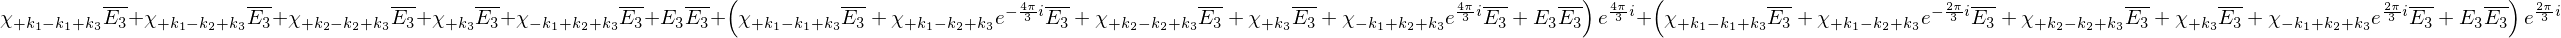

In [131]:
# try 3 step
phases = [0, sy.Rational(2,3)*sy.pi, sy.Rational(4,3)*sy.pi]
factors = [sy.exp(sy.I*p) for p in phases]
s = sum([f*detected_large.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(sy.I*p))])
     for f, p in zip(factors, phases)]
    )
# doesn't work. My program may need a 'Feynman Pathway' abstraction. Or maybe it does?
#sy.simplify(sy.re(s))
#s = s.expand(complex=True)
#sy.re(s), sy.im(s)
s

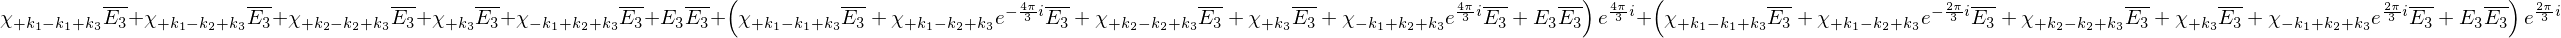

In [132]:
s.conjugate().conjugate()

In [133]:
s.expand(complex=True)

In [135]:
sy.re(s.expand(complex=True)), sy.im(s.expand(complex=True))

In [137]:
sy.re(s.expand(complex=True)) +sy.im(s.expand(complex=True))

In [120]:
# second 3-step
# try 3 step
phases = [0, sy.Rational(2,3)*sy.pi, sy.Rational(4,3)*sy.pi]
factors = [-sy.exp(sy.I*p) for p in phases]
s = sum([f*detected_large.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(sy.I*p))])
     for f, p in zip(factors, phases)]
    )
# doesn't work. My program may need a 'Feynman Pathway' abstraction. Or maybe it does?
#sy.simplify(sy.re(s))
s.expand(complex=True)

In [117]:
# try 4 step
phases = [0, sy.pi/2, sy.pi, 3*sy.pi/2]
factors = [sy.exp(sy.I*p) for p in phases]
sy.re(sum([f*detected_large.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(-sy.I*p))])
     for f, p in zip(factors, phases)]
    ))


In [118]:
phi12 = sy.symbols("\Delta\phi_{12}", real=True)
detected_large.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(sy.I*phi12))])


In [46]:
list(accumulate(range(5)))

NameError: name 'accumulate' is not defined

In [54]:
a_list = list(range(5))
iter(a_list).next()

In [55]:
list(accumulator(range(5)))

In [56]:
accumulated(range(5))

In [57]:
single_excitation([-1, +2, +3])

True

In [58]:
single_excitation([-1, -2, +3])

False

In [59]:
single_excitation([-1, -1, +3])

False

## See if we can deal with scatter

In [139]:
scat = sy.symbols(r'\alpha', real=True)
e1, e2, e3 = sy.symbols('E_1:4')
sig_w_scatter = sig+scat*(a1*e1+a2*e2)
sig_w_scatter = sy.expand(np.conjugate(sig_w_scatter)*sig_w_scatter)
## remove scatter cross terms (\alpha is small) # maybe that is what they call 'pump-pump scatter'
#sig_w_scatter = (sig_w_scatter + sy.O(scat**2)).removeO()
head = sig_w_scatter.func
# there is a problem with the complex conjugates. Or is there? maybe not in fourier space...
# But maybe we don't have to be in Fourier Space. 
sig_w_scatter = filter(lambda s: 'conjugate(\\chi' not in repr(s), sig_w_scatter.args)
# remove terms depending on double responses (vanishingly small)
sig_w_scatter = filter(lambda s: repr(s).count(r'\chi_')<2, sig_w_scatter)
# remove scatter-response cross-terms (small) ... maybe that is not needed
sig_w_scatter = filter(lambda s: not (r'\chi' in repr(s) and r'\alpha'  in repr(s)), sig_w_scatter)
sig_w_scatter = head(*sig_w_scatter)
sig_w_scatter

In [62]:
phases = [0, sy.I*sy.pi]
factors = [1, -1]
cycled = sum([f*sig_w_scatter.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(p))])
     for f, p in zip(factors, phases)]
    )
cycled

In [ ]:

sy.expand(sy.Integer(-1)**sy.Rational(2,3))

## Collinear geometry


In [150]:
# setup filters
col = multifilter([fundamental_freq, positive_last, single_excitation])
expr = sum(signals_for_order(i, n_pulses=3, filter_=col) for i in [1,2,3])
sig = sum([mul(*t) for t in zip(sy.symbols('E_1:4'), sy.symbols('A_1:4'))]) + expr
sig = sy.expand(sy.conjugate(sig)*sig)
head = sig.func
args = sig.args
# filter out conjugates while we learn about this
args = filter(lambda s: 'conjugate(\\chi' not in repr(s), args)
args = filter(lambda s: repr(s).count(r'\chi_')<2, args)
sig = head(*args)
sig

In [82]:
len(sig.args)

In [99]:
b1, b2, b3 = sy.symbols('b_1:4', non_negative=True, real=True)
phi1, phi2, phi3 = sy.symbols(r'\phi_1:4', real=True)
sigs = sig.subs([
        (a1, b1*sy.exp(-sy.I*phi1)),
        (a2, b2*sy.exp(-sy.I*phi2)),
        (a3, b3*sy.exp(-sy.I*phi3))
    ])

In [100]:
def find_sym(expr1, expr2):
    "Find expr1 in expr2. Returns a boolean if found."
    for a in sy.postorder_traversal(expr2):
        if expr1 == a:
            return True
    return False

find_sym(sy.sympify('x'), sy.sympify('x*y+1'))

True

In [101]:
# terms without phi1
filter(lambda x: not find_sym(phi1, x), sigs.args)#

In [148]:
# terms with chi_-k1+k2+k3
filter(lambda x: (
        find_sym(Signal([-1, 2, 3]), x)
        or find_sym(Signal([1,-2,3]), x)),
    sigs.args)

In [151]:
# try 2step, for fun
phases = [0, sy.pi]
# Next line follows Tan's nomenclature
factors = [sy.exp(sy.I*p) for p in phases]
sum([f*sig.subs([(a1, 1),
                          (a3, 1),
                          (a2, sy.exp(-sy.I*p))])
     for f, p in zip(factors, phases)]
    )